<a href="https://colab.research.google.com/github/1iushuran/IEOR231-Assignment/blob/A2/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a id='toc1_'></a>[IEOR 231 (25spring) Assignment 2](#toc0_)
This assignment consists of two questions: one on simulating a retail center and the other on simulating a bandit problem. Each question includes multiple sub-questions designed to guide you step by step through solving the simulation problems. The parameters in each question are provided incrementally, and unless otherwise specified, once a parameter is defined, it applies to all subsequent parts.

We provide examples and guidance code to help you complete the assignment. Your task is to fill in the codes in cells marked with `### TODO`. For some questions, we have partially implemented the code with statings and ends to make completion easier—you only need to complete the required functions or classes.


**Table of contents**<a id='toc0_'></a>    
  - [Question 1: Simulation of a retailing center](#toc1)    
    - [Q1.0 Overview of the Retailing Center](#toc1_0)    
    - [Q1.1 Simulate the queue in the retailing center and estimate waiting time](#toc1_1)    
      - [Q1.1.1 Intensity of arrival rate](#toc1_1_1)   
      - [Q1.1.2 Thinning method for simulating non-homogenous arrivals](#toc1_1_2)
      - [Q1.1.3 Simulate customer demand and service time](#toc1_1_3)
      - [Q1.1.4 Simulate the queue and waiting time](#toc1_1_4)
        - [Q1.1.4 (a) Simulation of the queue for one day](#toc1_1_4_a)
        - [Q1.1.4 (b) Simulation of the queue and waiting time for one day](#toc1_1_4_b)
    - [Q1.2 Price Boosting and optimization](#toc1_2)
      - [Q1.2.1 Queue simulation with price factors](#toc1_2_1)
      - [Q1.2.2 Finding the optimal price factor](#toc1_2_2)
    - [Q1.3 Inventory management of retail center](#toc1_3)
  - [Question 2: Multi-Armed Bandit](#toc2)    
    - [Q2.1 Inplementation of Bernoulli and Gaussian bandit](#toc2_1)
    - [Q2.2 Inplementation of Espsilon-greedy and Upper Confidence Bound](#toc2_2)
    - [Q2.3 Simulation and Regret Calculation](#toc2_3)

  


# <a id='toc1'></a>[Question 1: Simulation of a retailing center](#toc0_)

## <a id='toc1_0'></a>[Q1.0 Overview of the Retailing Center](#toc0_)

In Question 1, we model a simplified retailing center operating over a day (8 am–8 pm) where customers arrive according to a non-homogeneous Poisson process, request multiple products, and are served on a first-come, first-served (FIFO) basis. The system operates according to the following schema:

+ **Products:** The center stocks and sells $d = 5$ different products, the number of product can be fractional.
+ **Server:** There is a single centralized server managing all customer requests.
+ **Arrival Process:** Customers arrive sequentially between 8 am and 8 pm according to a non-homogeneous Poisson process and the center will serve all customers arrived. The arrival rate $\lambda(t)$ is defined by a general piecewise linear function:
  
  $$
  \lambda(t) =
  \begin{cases}
  \lambda_0 + \left(\dfrac{\lambda_{\text{peak}} - \lambda_0}{T_1 - T_0}\right)(t - T_0) & \text{for } T_0 \leq t \leq T_1, \\[10pt]
  \lambda_{\text{peak}} - \left(\dfrac{\lambda_{\text{peak}} - \lambda_{\text{end}}}{T_2 - T_1}\right)(t - T_1) & \text{for } T_1 < t < T_2,\\
  0 & \text{for }  t \geq T_2 \text{ or } t<T_0
  \end{cases}
  $$
  where:
  - $T_0 = 8$ am,
  - $T_1 = 12$ pm,
  - $T_2 = 20$ pm,
  - $\lambda_0$ is the arrival rate at 8 am,
  - $\lambda_{\text{peak}}$ is the peak arrival rate at 12 pm, and
  - $\lambda_{\text{end}}$ is the arrival rate at 8 pm.

+ **Customer Demand:** Each customer has an independent demand for the 5 different products, represented by the vector $(D_1, D_2, \cdots, D_5)$, drawn from a joint lognormal distribution $\text{Lognormal}(\mu,\Sigma)$.

+ **Service Time:** The server processes customers in FIFO order. The service time required for each customer follows a lognormal random variable with mean
  $
  m = \sum_{i=1}^{5} a_i D_i,
  $

  and variance
  $
  \text{Var} = \left(\sum_{i=1}^{5} a_i D_i\right)^2,
  $
  where the coefficients $(a_1, a_2, \cdots, a_5)$ are pre-specified. This service time reflects the effort needed to prepare, sort, and move the products in real time.
  
Detailed values of variables and parameters will be introduced in the questions.


## <a id='toc1_1'></a>[Q1.1 Simulate the queue in the retailing center and estimate waiting time](#toc0_)
In this question, we will simulate the queuing in the retail center with non-homogeneous arrival and lognormal service time in the retailing center from scratch. We will first simulate the non-homogeneous arriving process using thinning method, and then simulate the one-day queuing in the retail center. Our final target is to estimate the distribution of waiting time.

***Notes: For Q1.1 you can assume that the retail center has infinite supply for all products, and currently you do not need to consider the price boosting factor in Q1.2.***



### <a id='toc1_1_1'></a>[Q1.1.1 Intensity of arrival rate](#toc0_)
To get started, let's warm up by implementing python function `intensity(t)` for the arriving rate $\lambda(t)$, which will return the arriving rate at any given time $t\in[0,24)$. The parameters are set as $\lambda_0 = 10$, $\lambda_{peak} = 25$ and $\lambda_{end} = 8$.    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### parameters for the simulation
lambda0 = 10
lambda_peak = 25
lambda_end = 8

In [ ]:
### TODO: Implement intensity function
def intensity(t):
    """Piecewise linear intensity function, where t in [0,24]."""
    T0 = 8
    T1 = 12
    T2 = 20
    # construct the intensity based on the above piecewise function
    if t < T0 or t >= T2:
        return 0
    elif T0 <= t <= T1:
        return lambda0 + ((lambda_peak - lambda0) / (T1 - T0)) * (t - T0)
    else:
        return lambda_peak - ((lambda_peak - lambda_end) / (T2 - T1)) * (t - T1)

### <a id='toc1_1_2'></a>[Q1.1.2 Thinning method for simulating non-homogenous arrivals](#toc0_)

The thinning algorithm is a method for simulating non-homogeneous Poisson process, and let's review the following key steps:

1. **Determine an Upper Bound:**  
   Identify a constant $ \lambda_{\text{max}} $ such that $ \lambda(t) \leq \lambda_{\text{max}} $ for all $t$ in the simulation interval. In this problem the $\lambda_{\text{peak}}$ is a good choice.

2. **Generate Candidate Arrivals:**  
   Simulate a homogeneous Poisson process with the constant rate $ \lambda_{\text{max}} $ to generate candidate arrival times. This can be achieved through using Exponential distribution $\text{Exp}(\frac{1}{\lambda})$ with `np.random.exponential()`.

3. **Acceptance/Rejection Step:**  
   For each candidate arrival time $t$, accept the arrival with probability  
   $$ p_{accept} = \frac{\lambda(t)}{\lambda_{\text{max}}} $$  
   Otherwise, reject the candidate. This step ensures that the accepted arrivals follow the desired time-varying rate $ \lambda(t) $.

Now, let's implement the `simulate_arrivals(lambda_max=lambda_peak)`, which returns the array of cutsomers' arrival time in a day.


In [ ]:
T = 24 # indicating the hours in a day

In [ ]:
### TODO: complete simulate_arrivals function with thinning algorithm
def simulate_arrivals(lambda_max=lambda_peak):
    arrivals = []
    t = 0
    ###TODO: Implement the while loop to simulate the arrival process
    while t < T:
        t += np.random.exponential(1 / lambda_max)

        ## if out of period
        if t >= T:
            break

        p_accept = intensity(t) / lambda_max

        ## accept with this prob
        if np.random.uniform() < p_accept:
            arrivals.append(t)

    return np.array(arrivals)

### Tips: you can test your codes by testing arrivals < 8 and arrivals >= 20, which should be 0 since no arrivals in these time intervals.
# morning_arrivals = arrivals[arrivals < 8]
# afternoon_arrivals = arrivals[arrivals >= 20]

# Test our functions
arrivals = simulate_arrivals()
morning_arrivals = arrivals[arrivals < 8]
afternoon_arrivals = arrivals[arrivals >= 20]

print("arrivals b4 8am (no arrivals):", morning_arrivals)
print("arrival after 8pm (no arrivals):", afternoon_arrivals)


arrivals b4 8am (no arrivals): []
arrival after 8pm (no arrivals): []


### <a id='toc1_1_3'></a>[Q1.1.3 Simulate customer demand and service time](#toc0_)
Now let's move to the demand and service time part. We have $d=5$ types of products in total for consideration. Each customer has an independent demand for the 5 different products, represented by the vector $(D_1, D_2, \cdots, D_5)$, drawn from a joint lognormal distribution $\text{Lognormal}(\mu,\Sigma)$ (parameters in the following block). We directly provide you with two functions that might be useful in the following simulation:
1. `simulate_demand(mu, Sigma)`: simulate the demand for one customer
2. `lognormal_service_time(demand)`: turn the demand to service time

For the parameters, we have
+ $d = 5$
+ $\mu = np.array([0.5 , 0.7, 0.6, 0.5, 0.4])$
+ $\Sigma = np.eye(d)$  
+ $a = np.array([10, 15, 5, 15, 10])/3600$

In [ ]:
## Parameters for the demand
d = 5  # number of products is 8
mu = np.array([0.5 , 0.7, 0.6, 0.5, 0.4])
Sigma = np.eye(d)
a = np.array([10, 15, 5, 15, 10])/3600  # coefficients for products

In [ ]:
def simulate_demand(mu=mu, Sigma=Sigma):
    return np.exp(np.random.multivariate_normal(mu, Sigma))

def lognormal_service_time(demand):
    m = np.dot(a, demand)  # mean service time based on demand
    sigma2 = np.log(2)
    sigma = np.sqrt(sigma2)
    mu = np.log(m) - sigma2/2 if m > 0 else 0.0  # avoid log(0)
    # Draw from a lognormal distribution with parameters mu and sigma.
    return np.random.lognormal(mean=mu, sigma=sigma)

### <a id='toc1_1_4'></a>[Q1.1.4 Simulate the queue and waiting time](#toc0_)

#### <a id='toc1_1_4_a'></a>[Q1.1.4 (a) Simulation of the queue for one day](#toc0_)
Here we provide one **guided approach** to help you implement the queue simulation with `simulate_queue(arrivals)` which take a array of arrival time already simulated as input. You may also design your own functions for demand and service time as long as you return the required outputs.

1. **Define the Function**  
   - Create `simulate_queue(arrivals)` where `arrivals` is an array of arrival time simulated with `simulate_arrivals(lambda_max)`.

2. **Simulate Demand**  
   - For each arrival, generate a demand (e.g., with a `simulate_demand()` function).

3. **Derive Service Times**  
   - Convert the demands into service time (e.g., with a `lognormal_service_time()` function).

4. **Track the Queue**  
   - Use arrays or lists to record each arrived customer's:
     - Waiting time
     - Service start time
     - Service end time

5. **Calculate Waiting and Service Start**  
   - For each customer, set the service start time to the maximum of:
     - Their arrival time
     - The previous customer’s service end time  
   - Waiting time is the difference between the service start time and arrival time.

6. **Calculate Service End**  
   - For each customer, service end time is the sum of service start time and service time.

7. **Return Results**  
   - Return the list/array of waiting time for each arrived customer.


If you have alternative approaches of implementing, as long as your implementation can simulate the queue and provide required outputs, you can customize the details to fit your own simulation design.

***Task: Please complete the simulate_queue(arrivals) function.***

In [ ]:
### TODO: Implement simulate_queue function (suggested)
def simulate_queue(arrivals):
    n = len(arrivals)
    demands = [simulate_demand(mu, Sigma) for _ in range(n)]
    service_times = [lognormal_service_time(d) for d in demands]

    waiting_times = np.zeros(n)
    service_start_times = np.zeros(n)
    service_end_times = np.zeros(n)

    # For the first customer, waiting time is 0.
    service_start_times[0] = arrivals[0]
    service_end_times[0] = arrivals[0] + service_times[0]

    ###TODO: Complete the for loop to simulate the queue and calculate waiting times
    for i in range(1, n):
        service_start_times[i] = max(arrivals[i], service_end_times[i - 1])
        waiting_times[i] = service_start_times[i] - arrivals[i]
        service_end_times[i] = service_start_times[i] + service_times[i]

    return waiting_times


#### <a id='toc1_1_4_b'></a>[Q1.1.4 (b) Simulation of the queue and waiting time for one day](#toc0_)
Using `simulate_arrivals(lambda_max=lambda_peak)`, we can generate all customer arrival times for a single day. Next, we call `simulate_queue(arrival)` to obtain each customer's waiting time. By repeating this simulation 100 times, we can report the mean waiting time for morning and afternoon arrivals.

*Task: Please report the mean waiting time for customers whose arrivals are in the morning (before 12pm) and afternoon (after 12pm).*


In [ ]:
### TODO: Analysis and visualization of the waiting time distribution for morning arrivals and afternoon arrivals respectively.

# simulation for 100 times
repetitions = 100


### TODO: Repeat the simulation for 100 times and calculate the mean of waiting time for morning arrivals and afternoon arrivals respectively.
waiting_morning = []
afternooon_waiting = []
for _ in range(repetitions):
    arrivals = simulate_arrivals(lambda_max=lambda_peak)
    waiting_times = simulate_queue(arrivals)
    i_m = arrivals < 12
    i_a = arrivals >= 12

    ## seperate the time for mornign and afternoon
    waiting_morning.extend(waiting_times[i_m])
    afternooon_waiting.extend(waiting_times[i_a])

# convert the format
waiting_morning = np.array(waiting_morning)
afternooon_waiting = np.array(afternooon_waiting)

# compute the mean waiting time
mean_morning = np.mean(waiting_morning) if waiting_morning.size > 0 else 0.0
mean_afternoon = np.mean(afternooon_waiting) if afternooon_waiting.size > 0 else 0.0

### TODO: Report the results.
print("Mean of waiting time for morning arrivals:", mean_morning)
print("Mean of waiting time for afternoon arrivals:",mean_afternoon)

Mean of waiting time for morning arrivals: 0.14327447833576076
Mean of waiting time for afternoon arrivals: 0.3382909420790783


## <a id='toc1_2'></a>[Q1.2 Price Boosting and optimization](#toc0_)

In this section, we analyze how adjusting the price boosting factor, denoted by $p \in [1, 2]$, influences the overall performance of the retailing center. By applying a price boosting factor, the retailing center charges customers an increased price based on the value of $p$. However, this elevated charge may discourage some customers from entering the retail center.

At the start of a day, the server sets a price boosting factor $p$. When a customer arrives, with probability $p-1$, the customer would not enter and shop in the retailing center. We can notice that when setting $p=1$, the situation is just the same as the setting we discussed in previous question, and when setting $p=2$, the retailing center would not serve any customer.

Now, the retail center seeks to determine a price boosting factor $p$ that maximizes the following objective:
$$
\max_p \; \mathbb{E}\!\Bigg[
\sum_{j=1}^{N} \sum_{i=1}^{d} a_i \, D_{ij}
\;-\; c \times \Bigl(1 + \sum_{j=1}^N W_j\Bigr)^2
\Bigg],
$$
where:
- $N$ is the number of customers ultimately served by the retail center after applying the price boosting factor $p$ for one day,  
- $D_{ij}$ is the customer $j$'s demand for product $i$ ($j\in[1,2,\cdots,N]$ and $i\in[1,2,\cdots,d]$),  
- $a_i$ is the coefficient defined earlier in Q1.1.3 for product $i$,  
- $W_j$ is the waiting time experienced by customer $j$, and  
- $c$ is a given cost parameter.


***Notes: For Q1.2 you can assume that the retail center has infinite supply for all products.***

### <a id='toc1_2_1'></a>[Q1.2.1 Queue simulation with price factors](#toc0_)
Below, we will implement a function `simulate_queue_with_price(arrivals, p)` that models how the price boosting factor $p \in [1,2]$ influences customer behavior. Each arriving customer observes the boosted price and, with probability $p - 1$, decides to leave immediately.

**Function Requirements:**
- **Inputs:**
  1. `arrivals`: A list or array of arrival times for all customers.
  2. `p`: A floating-point number in \([1,2]\) indicating the price boosting factor.
- **Outputs:**
  1. The list of waiting time of cusotmers (required)



***Task: Please complete the simulate_queue_with_price(arrivals, p) function. Test your codes with $p=1.4$ and report the average of waiting time for morning and afternoon arrivals with 100 repetitions of simulation.***


Hints: you can directly call `simulate_queue()` in your code for `simulate_queue_with_price(arrivals, p)`.



In [ ]:
p = 1.4  # boosting factor

In [ ]:
### TODO: Implement simulate_queue_with_price function
def simulate_queue_with_price(arrivals, p):
    """
    Simulate the queue with price boosting.

    Each customer is served with probability (1 - (p-1)).
    If no customers are served, return empty arrays.

    return the lists of indices of served customers and corresponding waiting times, you can return other information for analysis and future use.
    """
    l = []
    served_arr = []

    for i, t in enumerate(arrivals):
        if np.random.uniform() < (1 - (p-1)):
            l.append(i)
            served_arr.append(t)

    served_arr = np.array(served_arr)

    ## no customer joins
    if len(served_arr) == 0:
        return l, served_arr, np.array([])

    waiting_times = simulate_queue(served_arr)
    return l, served_arr, waiting_times


In [ ]:
### TODO: Report the average waiting time for morning and afternoon arrivals with price boosting factor p = 1.4 using 100 times simulation.
repetitions = 100

waiting_morning2 = []
afternooon_waiting2 = []
### TODO: Repeat the simulation for 100 times and calculate the mean of waiting time for morning arrivals and afternoon arrivals respectively.
for _ in range(repetitions):
    arrivals = simulate_arrivals(lambda_max=lambda_peak)
    l, served_arr_l, waiting_times = simulate_queue_with_price(arrivals, p)

    # Separate them
    morning_arr = served_arr_l < 12
    afternoon_arr = served_arr_l >= 12

    waiting_morning2.extend(waiting_times[morning_arr])
    afternooon_waiting2.extend(waiting_times[afternoon_arr])

# convert format
waiting_morning2 = np.array(waiting_morning2)
afternooon_waiting2 = np.array(afternooon_waiting2)

# comput means
mean_morning2 = np.mean(waiting_morning2) if waiting_morning2.size > 0 else 0.0
mean_afternoon2 = np.mean(afternooon_waiting2) if afternooon_waiting2.size > 0 else 0.0


### TODO: Report the average waiting time
print("Mean of waiting time for morning arrivals with price boosting:",mean_morning2 )
print("Mean of waiting time for afternoon arrivals with price boosting:",mean_afternoon2 )

Mean of waiting time for morning arrivals with price boosting: 0.0614018873207903
Mean of waiting time for afternoon arrivals with price boosting: 0.060684245995539746


### <a id='toc1_2_2'></a>[Q1.2.2 Finding the optimal price factor](#toc0_)
Now let's find the optimal $ p \in [1,2] $ that maximizes our objective function. Since it is difficult to derive closed-form solutions for this problem, we encourage you to simulate the results for different values of $ p $ and compare the estimated expected values of the objective function. Please report your results rounded to two decimal places.

***Task: Please complete the simulate_day(p, c=0.005, n_sim=100) function and find the optimal $ p \in [1,2] $ that maximizes our objective function***

In [ ]:
### Parameters:
c=0.005 # cost parameter

In [ ]:
# update our helper function
def simulate_queue(arrivals):
    n = len(arrivals)
    demands = [simulate_demand(mu, Sigma) for _ in range(n)]
    service_times = [lognormal_service_time(d) for d in demands]

    waiting_times = np.zeros(n)
    service_start_times = np.zeros(n)
    service_end_times = np.zeros(n)
    price = np.zeros(n)

    service_start_times[0] = arrivals[0]
    service_end_times[0] = arrivals[0] + service_times[0]
    price[0] = np.dot(a, demands[0])

    for i in range(1, n):
        service_start_times[i] = max(arrivals[i], service_end_times[i - 1])
        waiting_times[i] = service_start_times[i] - arrivals[i]
        service_end_times[i] = service_start_times[i] + service_times[i]
        price[i] = np.dot(a, demands[i])

    return waiting_times, price

def simulate_queue_with_price(arrivals, p):
    l = []
    served_arr = []

    for i, t in enumerate(arrivals):
        if np.random.uniform() < (1 - (p-1)):
            l.append(i)
            served_arr.append(t)

    served_arr = np.array(served_arr)
    if len(served_arr) == 0:
        return l, served_arr, np.array([]), np.array([])

    waiting_times, price = simulate_queue(served_arr)
    return l, served_arr, waiting_times, price


In [ ]:
### TODO: find the optimal price boosting factor p that maximizes the expected objective, with c=0.005.
def simulate_day(p, c=0.005, n_sim=100):
    """
    Simulate a full day of operation for a given price boosting factor p.

    - p: Price boosting factor in [1, 2].
    - c: Cost penalty coefficient.
    - n_sim: Number of simulation runs.

    Tips for each simulation run:
      1. Generate a full day arrival process.
      2. Apply the simulate_queue_with_price(arrivals, p) for simulating the queue.
      3. Compute revenue as the sum over served customers: dot(a, demand).
      4. Compute the cost penalty as c*(1+total waiting time)^2.
    """
    objective_values = []
    ###TODO: Implement the simulation loop and document the objective values under the given p
    for _ in range(n_sim):
        arrivals = simulate_arrivals(lambda_max=lambda_peak)
        l, served_arr, waiting_times, price = simulate_queue_with_price(arrivals, p)

        total_revenue = np.sum(price) if price.size > 0 else 0.0
        total_wait = np.sum(waiting_times) if waiting_times.size > 0 else 0.0

        cost_penalty = c * (1 + total_wait)**2

        objective_values.append(total_revenue - cost_penalty)

    return np.mean(objective_values)



### TODO: Report the optimal price boosting factor p that maximizes the expected net benefit.
p_values = np.linspace(1, 2, 21)
objectives = []

for p in p_values:
    obj = simulate_day(p, c=c, n_sim=100)
    objectives.append(obj)

optimal_index = np.argmax(objectives)
optimal_p = p_values[optimal_index]

print("Optimal p:", round(optimal_p, 2))

Optimal p: 1.35


## <a id='toc1_3'></a>[Q1.3 Inventory management of retail center](#toc0_)

 ***Notes: the price boosting factor is set as p=1 for Q1.3***.

In this question, we extend the retailing center simulation described in **Q1.0** by incorporating **inventory decision**. While the arrival process, customer demand, and service times remain as in Q1.0, we now account for the fact that the retailing center may experience periods of limited stock for each product. To meet the demand from customers, the center must frequently replenish its inventory by placing order from its supplier. Holding inventory incurs a storage cost. Additionally, when demand exceeds available stock during a day, the shortage can be filled by 'borrowing' from nearby stores at an external cost from its supplier. In summary, there are two costs associated with inventory:

+ **Storage Cost:** At the end of each day, each unit of product remaining in stock incurs a storage cost of $ c_{\text{storage}} $.
+ **External Cost:** For each unit of unsatisfied demand (i.e., lost sales) during the day, the retailing center incurs an external cost $ c_{\text{external}} $ of borrowing.
+  For simplicity, $c_{\text{storage}}$ for all products are the same and $c_{\text{external}}$ for all products are the same.

To decide when and how many products to place an order to the retailing center's supplier, we consider a simple (r,Q) policy for inventory management decsion. The simple idea of (r,Q) policy is to place an order of $Q\in\mathbb{R}^d$ every $r$ days. Some new details for the inventory costs and (r,Q) policy are summarized below:

**(r, Q) Inventory Policy**
1. **Review Period:** Inventory is reviewed every $ r $ days (e.g., 2 days).
2. **Order Quantity:** On a review day, an order of size $Q$ (a vector of length $d$) is placed for each product.
3. **Lead Time:** Orders are subject to an exponential lead time after placing the order, $L \sim \text{Exp}(1/\mu_{\text{lead}})$.
4. **End-of-Day Update:** Regardless of when an order arrives during the day, if it arrives intra-day, it is held until next-day update. Orders are then added to the inventory as the starting stock level for the next day. (the new order will not encounter storage cost for the previous day).
5. **External Procurement:** If customer demand during the day exceeds on-hand inventory, the shortfall is met by external stores at a cost of $c_{\text{external}}$ per unit.


We assume that the retailing center has infinity size of storage space. What we would like to do is implemnting the function `simulate_rQ(r, Q, initial_inventory, num_days, external_cost, lead_mean, storage_cost)` that can simulate the costs of inventory for num_days.

Further we would like simulate the (r,Q) policy for 50 days and estimate the final total inventory cost for the following two (r,Q) policy:
1. $r=2, Q=(1000, 1000, 1000, 1000, 1000)$
2. $r=5, Q=(3000, 3000, 3000, 3000, 3000)$

We assume at the starting date, the inventory starts with $Q$ under (r,Q) policy.

***Task: Please complete the simulate_multi_day_policy(r, Q, num_days, external_cost, lead_mean, storage_cost) function and compare two policies above.***


In [ ]:
### Parameters needed
### arrival info
lambda0 = 10
lambda_peak = 25
lambda_end = 8
p = 1 # price boosting factor

### demand info
d  = 5
mu = np.random.uniform(0, 1, d)
Sigma = np.eye(d)
a = np.array([10, 15, 5, 15, 10])/3600


### Inventory management
num_days = 50  #Days for simulating the inventory policy
external_cost = 0.05    # Penalty cost per unit from external store (for unmet demand)
lead_mean = 1.5        # Mean lead time in days (exponential distribution)
storage_cost = 0.01     # Storage cost per unit per day


In [ ]:
import math
### TODO: Implement simulate_multi_day_policy function
def simulate_multi_day_policy(r, Q, num_days, external_cost, lead_mean, storage_cost):
    """
    Simulate inventory operations over multiple days under an (r, Q) policy.
    Parameters:
      r             : Review period in days (e.g., 2 or 5)
      Q             : Order quantity vector (length d), e.g., np.array([q1, q2, ..., q5])
      initial_inventory : Starting inventory vector (length d) at day 1 morning.
      num_days      : Total number of days to simulate.
      external_cost : Penalty cost per unit if demand is met externally.
      lead_mean     : Mean of the exponential lead time.
      storage_cost  : Cost per unit of inventory held overnight.

    Returns:
        total_inventory_cost during the simulate period
    """
    total_external_cost = 0.0
    total_storage_cost = 0.0
    total_orders_placed = 0
    final_inventory_acc = np.zeros(d)

    # Start with the initial inventory at day 1
    current_inventory = Q

    # Outstanding orders: list of tuples (delivery_day, order_quantity_vector)
    outstanding_orders = []

    ### TODO: Simulate each day and document the cost
    for day in range(1, num_days + 1):
        received_orders = [order for order in outstanding_orders if order[0] == day]
        for delivery_day, order_qty in received_orders:
            current_inventory += order_qty
        outstanding_orders = [order for order in outstanding_orders if order[0] > day]

        ## today sales
        arrivals = simulate_arrivals(lambda_max=lambda_peak)
        day_external_cost = 0.0

        for _ in arrivals:
            demand_vector = simulate_demand(mu, Sigma)
            for i in range(d):
                if current_inventory[i] >= demand_vector[i]:
                    current_inventory[i] -= demand_vector[i]
                else:
                    shortage = demand_vector[i] - current_inventory[i]
                    day_external_cost += external_cost * shortage
                    current_inventory[i] = 0.0

        day_storage_cost = np.sum(current_inventory) * storage_cost

        total_external_cost += day_external_cost
        total_storage_cost += day_storage_cost

        if day % r == 0:
            lead_time = np.random.exponential(scale=lead_mean)
            delivery_day = int(math.ceil(day + lead_time))
            if delivery_day <= day:
                delivery_day = day + 1
            outstanding_orders.append((delivery_day, Q.copy()))
            total_orders_placed += 1

    total_inventory_cost = total_external_cost + total_storage_cost
    return total_inventory_cost

In [ ]:
### TODO: simulate the two (r, Q) policies


# Policy 1: Review every 2 days, order quantity of 1000 units per product.
r1 = 2
Q1 = np.array([1000, 1000, 1000, 1000, 1000])

# Policy 2: Review every 5 days, order quantity of 1000 units per product.
r2 = 5
Q2 = np.array([3000, 3000, 3000, 3000, 3000])

# We run multiple replications to average out the randomness.
replications = 100
costs_policy1 = []
costs_policy2 = []

for _ in range(replications):
    cost1 = simulate_multi_day_policy(r1, Q1, num_days, external_cost, lead_mean, storage_cost)
    costs_policy1.append(cost1)

    cost2 = simulate_multi_day_policy(r2, Q2, num_days, external_cost, lead_mean, storage_cost)
    costs_policy2.append(cost2)

mean_cost_policy1 = np.mean(costs_policy1)
mean_cost_policy2 = np.mean(costs_policy2)
### TODO: report the inventory cost for each policy
print("Average total inventory cost over {} days (Policy 1: r=2, Q=[1000,...,1000]): ${:.2f}".format(num_days, mean_cost_policy1))
print("Average total inventory cost over {} days (Policy 2: r=5, Q=[3000,...,3000]):   ${:.2f}".format(num_days, mean_cost_policy2))



# print("=== Policy 1: (r = 2 days, Q = [1000, 1000, 1000, 1000, 1000]) ===")
# print("Inventory cost:",)


# print("=== Policy 2: (r = 2 days, Q = [3000, 3000, 3000, 3000, 3000]) ===")
# print("Inventory cost:",)



Average total inventory cost over 50 days (Policy 1: r=2, Q=[1000,...,1000]): $5811.47
Average total inventory cost over 50 days (Policy 2: r=5, Q=[3000,...,3000]):   $5810.14
=== Policy 2: (r = 2 days, Q = [3000, 3000, 3000, 3000, 3000]) ===
Inventory cost:


# <a id='toc2'></a>[Question 2: Multi-Armed Bandit](#toc0_)
For the Q2, we will implement and compare several multi-armed bandit algorithms across different reward distributions. We will work with two types of bandit environments:
- **Bernoulli Bandit:** Each arm gives a binary reward (0 or 1).
- **Gaussian Bandit:** Each arm’s reward is drawn from a Gaussian (Normal) distribution.


We will implement two algorithms **Epsilon-Greedy**, **UCB (Upper Confidence Bound)**.


## <a id='toc2_1'></a>[Q2.1 Inplementation of Bernoulli and Gaussian bandit](#toc0_)
We start with an provided example of `BernoulliBandit`.
In a Bernoulli bandit, we have $n$ arms,  each arm $i\in{1,2,\cdots,n}$ provides a reward of 1 with probability $p_i$ and 0 otherwise. The reward is modeled as:
$$
r_i \sim \text{Bernoulli}(p_i)
$$
To initialize a `BernoulliBandit`, what we need is a list of probabilities indicating the probability of providing a reward of 1 when pulling arms. Then the `pull` method take in an arm index, and returns a reward of 1 with probability of the index input.

In [ ]:
### EXAMPLE: a simple Bernoulli bandit algorithm
class BernoulliBandit:
    def __init__(self, probabilities):
        self.probabilities = probabilities
        self.n_arms = len(probabilities)
    def pull(self, arm):
        return 1 if np.random.rand() < self.probabilities[arm] else 0

### test case
probabilities = [0.2, 0.5, 0.75]
bandit = BernoulliBandit(probabilities)
reward = bandit.pull(1)  # Returns 1 with probability 0.5, otherwise 0
print(reward)

0


Now let's implement `GaussianBandit`. In a Gaussian bandit, each arm $i \in \{1,2,\dots,n\}$ provides a reward that follows a normal (Gaussian) distribution:

$$
r_i \sim \mathcal{N}(\mu_i, \sigma_i^2)
$$

where:
- $\mu_i$ is the true mean reward of arm $i$.
- $\sigma_i^2$ is the variance of the reward distribution for arm $i$.



To complete the implementation of the `GaussianBandit` class, follow these steps:

1. Initialize the environment: The constructor should take two lists:
  + A list of mean rewards $\mu = [\mu_1, \mu_2, \dots, \mu_n]$.
  + A list of standard deviations $\sigma = [\sigma_1, \sigma_2, \dots, \sigma_n]$.

2. Implement the pull function: When an arm $i$ is pulled, generate a reward using the normal distribution:
    $r_i = \mathcal{N}(\mu_i, \sigma_i^2)$

***Task: Please complete the built-in functions of GaussianBandit.***

In [ ]:
### TODO: Implement the GaussianBandit class
class GaussianBandit:
    ### TODO: Implement the __init__
    def __init__(self, means, stds):
        self.means = means
        self.stds = stds
        self.n_arms = len(means)

    ### TODO: Implement the pull method
    def pull(self, arm):
       reward = np.random.normal(self.means[arm], self.stds[arm])
       return reward


## test case
means = [0, 1, 2]
stds = [1, 1, 1]
bandit = GaussianBandit(means, stds)

reward = bandit.pull(1)  # Pull the second arm
print(reward)


-0.4862656952606663


## <a id='toc2_2'></a>[Q2.2 Inplementation of Espsilon-greedy and Upper Confidence Bound](#toc0_)
In this section we implement two bandit agoritms to identify the arm with highest mean rewards while try to minimize the expected regret during the process. The epsilon-greedy algorithm selects a random arm with probability $\epsilon$ (exploration) and selects the arm with the highest estimated reward with probability $1-\epsilon$ (exploitation). The selection rule is given by:
$$
i_t =
\begin{cases}
\text{random arm} & \text{with probability } \epsilon, \\
\arg\max_i \hat{\mu}_i & \text{with probability } 1-\epsilon,
\end{cases}
$$
where $\hat{\mu}_i$ is the estimated mean reward for arm $i$.

To implement the class `EpsilonGreedy`, we include three fucntions:
+ `__init__(self, n_arms, epsilon)`: Initialize the algorithm with number of arms and espilon.
+ `select_arm(self)`: select the arm to pull based on current estimation with epsilon-greedy rule.
+ `update(self, chosen_arm, reward)`: update estimation for arm's rewards after observing the pulling results.


In [ ]:
### EXAMPLE: implementation of the epsilon-greedy algorithm
class EpsilonGreedy:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)  # Number of plays for each arm
        self.values = np.zeros(n_arms)  # Estimated average reward for each arm

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            return np.argmax(self.values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * self.values[chosen_arm] + (1 / n) * reward

### test case with bernoulli bandit
n_arms = 5
probabilities = [0.1, 0.3, 0.5, 0.7, 0.9]  # True success probabilities of each arm
bandit = BernoulliBandit(probabilities)
# Initialize the Epsilon-Greedy agent
epsilon = 0.1
agent = EpsilonGreedy(n_arms, epsilon)
# Define the number of rounds
n_rounds = 100
# Track rewards
rewards = np.zeros(n_rounds)
# Run the simulation
for t in range(n_rounds):
    chosen_arm = agent.select_arm()  # Agent selects an arm
    reward = bandit.pull(chosen_arm)  # Bandit generates a reward
    agent.update(chosen_arm, reward)  # Update the agent's knowledge


The Upper Confidence Bound (UCB) algorithm selects the arm that maximizes the following expression:
$$
i_t = \arg\max_i \left( \hat{\mu}_i + \sqrt{\frac{2 \ln t}{n_i}} \right),
$$
where:
- $t$ is the total number of rounds,
- $n_i$ is the number of times arm $i$ has been played, and
- $\hat{\mu}_i$ is the estimated mean reward of arm $i$.

Implement the algorithm `UCB` in the following cell. You can refer to the example implementation of `EpsilonGreedy`. The `UCB` also has three functions for you to implement.
+ `__init__(self, n_arms, epsilon)`: Initialize the algorithm with number of arms and espilon
+ `select_arm(self)`: select the arm to pull based on current estimation
+ `update(self, chosen_arm, reward)`: update estimation for arm's rewards after observing the pulling results.
+
***Task: Please complete the built-in functions of UCB.***

In [ ]:
### TODO: Implement the UCB algorithm
class UCB:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.total_counts = 0

    ### TODO: Implement the UCB algorithm to select the arm
    def select_arm(self):
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        result = self.values + np.sqrt(2 * np.log(self.total_counts) / self.counts)

        return np.argmax(result)

    ### TODO: Implement the UCB algorithm to update the value of the chosen arm
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        self.total_counts += 1

        n = self.counts[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * self.values[chosen_arm] + (1 / n) * reward




## <a id='toc2_3'></a>[Q2.3 Simulation and Regret Calculation](#toc0_)
In this section we compare the short/long run performance of UCB and esiplon greedy algorithms in terms of regret.

The **regret** at time $t$ is defined as the cumulated difference between the **reward of the optimal arm** and the **reward obtained** by the algorithm:

$$
\text{Regret}(t) = \sum_{s=1}^{t} (\mu^* - r_s),
$$
where:
- $\mu^* = \max_{i} \mu_i$ is the true mean reward of the best arm.
- $r_s$ is the reward obtained at round $s$.

We would like to compare the UCB and epsilon-greedy algorithm with $\epsilon=0.1$ on a Bernoulli bandit in terms of regret for different time horizon $t$. The parameters are provided in the next cell. We would like to run the sumulation for 100 times, each experiment last for 1000 pulls. Please complete the simulation loop and visualize the mean accumulative regret in each rounds with $\pm 2\sigma$ confidence interval. What can you observe the regret performance of the two algorithms in short run horizon ($t<100$) and long run horizon ($t>600$)?

***Task: Please complete run 100 simulations, each last for 1000 rounds (pulls) using both algorithms and visualize the cummulative regrets and corresponding $\pm 2\sigma$ confidence interval. And summarize the regret performance of the two algorithms in short run horizon ($t<100$) and long run horizon ($t>600$)***

In [ ]:
#### Parameters of the bandit settings
# Define the bandit environment
n_arms = 5
probabilities = [0.1, 0.3, 0.5, 0.7, 0.9]  # True success probabilities
bandit = BernoulliBandit(probabilities)

# Initialize the algorithms
epsilon = 0.1
eg_agent = EpsilonGreedy(n_arms, epsilon)
ucb_agent = UCB(n_arms)

# Number of rounds for each simulation experiment
n_rounds = 1000

# Run multiple experiments to get mean and confidence intervals
repetitions = 100

optimal_mean = np.max(probabilities)

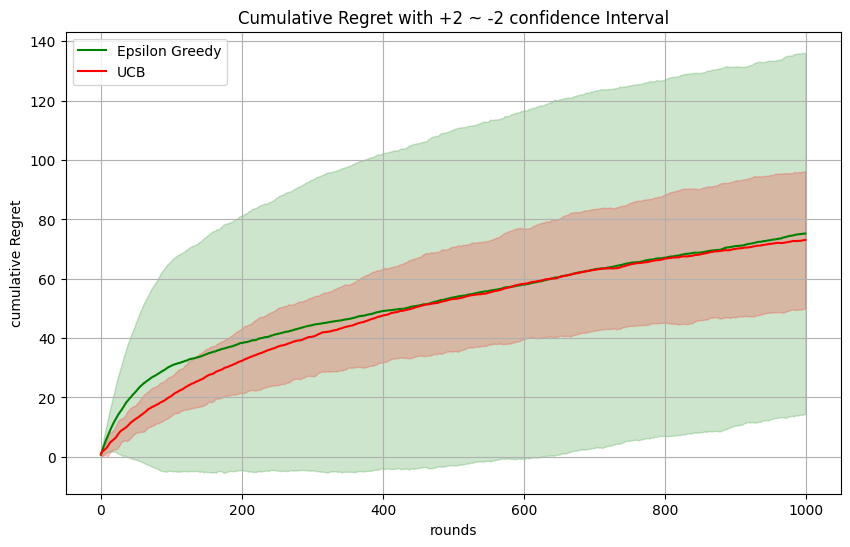

In [ ]:
### TODO: Implement the multiple experiments loop and visualize the results
all_regret_eg = np.zeros((repetitions, n_rounds))
all_regret_ucb = np.zeros((repetitions, n_rounds))

### TODO: Complete multiple experiments loop
for exp in range(repetitions):
    bandit = BernoulliBandit(probabilities)
    eg_agent = EpsilonGreedy(n_arms, epsilon)
    ucb_agent = UCB(n_arms)

    cum_regret_eg = 0
    cum_regret_ucb = 0

    for t in range(n_rounds):
        ## epsilon-greedy
        chosen_arm = eg_agent.select_arm()
        reward = bandit.pull(chosen_arm)
        eg_agent.update(chosen_arm, reward)
        cum_regret_eg += (optimal_mean - reward)
        all_regret_eg[exp, t] = cum_regret_eg

        ## UCB
        chosen_arm = ucb_agent.select_arm()
        reward = bandit.pull(chosen_arm)
        ucb_agent.update(chosen_arm, reward)
        cum_regret_ucb += (optimal_mean - reward)
        all_regret_ucb[exp, t] = cum_regret_ucb


### TODO: Visualize the cumulative regret with confidence intervals
mean_regret_eg = np.mean(all_regret_eg, axis=0)
std_regret_eg  = np.std(all_regret_eg, axis=0)

mean_regret_ucb = np.mean(all_regret_ucb, axis=0)
std_regret_ucb  = np.std(all_regret_ucb, axis=0)
plt.figure(figsize=(10,6))

# epsilon greedy
plt.plot(mean_regret_eg, label='Epsilon Greedy', color='green')
plt.fill_between(range(n_rounds),
                 mean_regret_eg - 2*std_regret_eg,
                 mean_regret_eg + 2*std_regret_eg,
                 color='green', alpha=0.2)

# UCB
plt.plot(mean_regret_ucb, label='UCB', color='red')
plt.fill_between(range(n_rounds),
                 mean_regret_ucb - 2*std_regret_ucb,
                 mean_regret_ucb + 2*std_regret_ucb,
                 color='red', alpha=0.2)

plt.xlabel('rounds')
plt.ylabel('cumulative Regret')
plt.title('Cumulative Regret with +2 ~ -2 confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

